In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import joblib
from sklearn import svm
import torch
from torch import nn
import warnings

In [2]:
# define the path where the data is persisted
STORAGE_PATH = "../../persisted_data/feather/{}.feather"
STORAGE_PATH_MODELS = "../../persisted_data/models/{}"
def load_data_set(name):
    data = pd.read_feather(STORAGE_PATH.format(name))
    return data

# Portfolio simulation

The following section defines all the functionally needed to evaluate stock trading strategies. The simulation calculates the changes happening in terms of price changes for each individual position over time.

This simulation is not considering any transaction costs, but only the theoretical portfolio value when holding certain stock positions according to some trading rule. Also a theoretical rebalance of the positions is applied daily, which is not feasable in reality. Therefore the results are not the actual performance, which could be achieved in realistic situtions.

In [3]:
# extract the price changes from each stock  and pad them with zeros
# such that the series has the same length for all stocks
def get_price_changes(stock, max_trading_days):
    # retrieve the length of this stock
    size = stock.shape[0]
    # determine the changes in price normalized by the previous price
    price_changes = np.diff(stock["current_price"]) / stock["current_price"][:size - 1]
    # set the changes to zero if no data exists
    return np.append(np.zeros(max_trading_days - size), price_changes)

# extraxt the positions taken in the stock according to the provided trading rule
def get_portfolio_positions(stock, rule, max_trading_days):
    # retrieve the length of this stock
    size = stock.shape[0]
    # calculate the position for each time point using the trading rule
    position = rule(stock)
    # not position can be taken, before the stock data exists
    return np.append(np.zeros(max_trading_days - size), position)

# a function simulating the performance of a trading rule applied to multiple stocks
def simulate_performance(stock_data, rule, weights=None, leverage=1):
    # get the length of the largest data set in trading days
    trading_days = np.max(stock_data.map(lambda stock: stock.shape[0]))
    
    # calculate the changes for each stock and transform the series of data frames into one data frame
    price_changes = stock_data.apply(get_price_changes, args=(trading_days, ))
    price_changes = pd.DataFrame(price_changes.values.tolist(), index=price_changes.index).T
    
    # calculate the positions in the stock and transform the series of data frames into one data frame
    portfolio_positions = stock_data.apply(get_portfolio_positions, args=(rule, trading_days, ))
    portfolio_positions = pd.DataFrame(portfolio_positions.values.tolist(), index=portfolio_positions.index).T
    
    if weights is None:
        # no special weights are chosen, decide the rebalancing to happen with equal weights
        weights = np.ones(portfolio_positions.shape[1]) / portfolio_positions.shape[1]
    
    # update the positions according to the maximal leverage chosen
    weights = weights * leverage / np.sum(weights)
    
    # calculate all individual components influencing the portfolio change
    portfolio_positions = portfolio_positions * weights
    individual_changes = price_changes * portfolio_positions
    total_changes = np.sum(individual_changes, axis=1)

    # update the value of the portfolio iteratively
    portfolio_total = np.ones_like(total_changes)
    for index in range(portfolio_total.shape[0] - 1):
        portfolio_total[index + 1] = portfolio_total[index]  * (1 + total_changes[index])
    
    return portfolio_total, portfolio_positions

In [4]:
# plot all portfolio developments
def plot_performance(strategies, title="Performance comparison of multiple trading strategies"):
    plt.figure(figsize=(15,8))
    for name, performance in strategies.items():
        plt.plot(np.arange(len(performance)), performance, label=name)
    
    plt.title(title)
    plt.legend()
    plt.xlabel("Trading days")
    plt.ylabel("Portfolio change")
    plt.show()

In [5]:
# create a set of strategies, simulate and plot them
def compare_strategies_portfolio(stock_data, chosen_strategies, leverage=1):
    strategies = chosen_strategies.copy()
    
    stock_data_lengths = stock_data.map(lambda stock: stock.shape[0])
    longest_trading_history = np.max(stock_data_lengths)
    leverage_buy_and_hold = np.sum(stock_data_lengths) / (longest_trading_history * len(stock_data_lengths))
    
    # retrieve the price data from each stock, prepend ones for missing data
    current_price = stock_data.map(lambda stock: pd.concat(
        [pd.Series(np.ones(longest_trading_history - stock.shape[0])), stock["current_price"]], 
        ignore_index=True)).tolist()
    current_price = pd.concat(current_price, axis=1)
    # initialize the portfolio performances with the buy and hold strategy
    performances = {
        "buy and hold\nleverage: {:.2f}".format(leverage_buy_and_hold) : np.mean(current_price, axis=1).values
    }
    
    # more than one stock is used, the revalancing strategy is used for comparison
    if current_price.shape[1] > 1:
        strategies["rebalancing"] = lambda stock: np.ones(stock.shape[0])
    
    # iteratively calculate the performance of the other strategies
    for name, strategy in strategies.items():
        performance, positions = simulate_performance(stock_data, strategy, leverage=leverage)
        mean_positions = np.mean(np.sum(positions, axis=1))
        performances["{}\nleverage: {:.2f}".format(name, mean_positions)] = performance

    plot_performance(performances)

In [6]:
# a help function used when only working with one stock ticker
def compare_strategies_individual(stock, chosen_strategies, leverage=1):
    stock_data = pd.Series({"stock": stock})
    compare_strategies_portfolio(stock_data, chosen_strategies, leverage=leverage)

# Trading strategies
A trading strategy or rule, as it is implemented here, is a rule assigning a desired position to every time point for each stock. The trading rule can take advantage of any indicator evaluated until the given time point.

## The regulating speculator
This strategy uses the position of the current price within a range defined by the bollinger bands, support and resistance lines or regression lines. The position is chosen to be higher, when the price is low in comparison to the range defined by the indicators.

In [7]:
# abstract definition of a regulating speculator
# the trading rule is constructed using the indicators, which are considered
def regulating_speculator(stock, indicators, min_position=0, max_position=1):
    # a nanmean of an empty slice triggers a warning, but returns nan, which is correct
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # get the indicator data
    indicator_values = stock[indicators]
    
    # calculate the mean, if possible
    mean_features = np.nanmean(indicator_values, axis=1)
    
    # the rule causes a higher position in the stock, if the indicators are low (potentially underpriced)
    rule = (1 - np.where(np.isnan(mean_features), 0, mean_features)) / 2
    
    # clip the resulting rule 
    return np.clip(rule, min_position, max_position)

In [8]:
# define the indicators used for the different strategies
bollinger_indicators = indicators_bollinger = ["bollinger_position20_2", "bollinger_position50_2", "bollinger_position100_2", "bollinger_position200_2"]
horizontal_indicators = ["horizontal_position20", "horizontal_position50", "horizontal_position100", "horizontal_position200"]
regression_indicators = ["regression_position20", "regression_position50", "regression_position100", "regression_position200"]
mixed_indicators = ["bollinger_position50_2", "horizontal_position100", "regression_position100"]

# define the regulating strategies
regulating_speculator_strategies = {
    "bollinger speculator": lambda stock: regulating_speculator(stock, bollinger_indicators, 0, 1),
    "support resistance speculator": lambda stock: regulating_speculator(stock, horizontal_indicators, 0, 1),
    "regression position speculator": lambda stock: regulating_speculator(stock, regression_indicators, 0, 1),
    "mixed regulating speculator": lambda stock: regulating_speculator(stock, mixed_indicators, 0, 1)
}

## Trend follower
The trend of a stock is defined to be positive, if a faster moving average is above the slower moving average.
This rule takes a position in a stock, if the trend is positive.

In [9]:
# define the trend follower strategy
def trend_follower(stock, trend):
    return np.where(np.isnan(stock[trend]), 0, np.where(stock[trend] > 0, 1, 0))

trend_follower_strategies = {
    "ma trend 20-50" : lambda stock: trend_follower(stock, "ma_trend20_50"),
    #"ma trend 50-100" : lambda stock: trend_follower(stock, "ma_trend50_100"),
    "ma trend 50-200" : lambda stock: trend_follower(stock, "ma_trend50_200")
}

## Moving average balancer
The moving average is an objective measure of fair price. If the price is above the moving average, it is objectively "high" and "low" otherwise. This rule sets a position in a stock, when the price is below a moving average.

In [10]:
def moving_average_balancer(stock, ma):
    return np.where(stock[ma] > 0, 1, 0)

ema_strategies = {
    "ema10 balancer": lambda stock: moving_average_balancer(stock, "ema10"),
    "ema20 balancer": lambda stock: moving_average_balancer(stock, "ema20"),
    "ema50 balancer": lambda stock: moving_average_balancer(stock, "ema50"),
    "ema100 balancer": lambda stock: moving_average_balancer(stock, "ema100"),
    "ema200 balancer": lambda stock: moving_average_balancer(stock, "ema200")
}

## SVM Classifier


In [11]:
# load the svm classifier
svm_indicators = ["sma10", "sma20", "sma50", "sma100", "lwma10", "lwma20", "lwma50", "lwma100", "lwma200",
              "ema10", "ema20", "ema50", "ema100", "rate_of_change20", "rate_of_change50", 
              "horizontal_position20", "horizontal_position50", "horizontal_position100",
              "regression_position20", "regression_position50", "regression_position100",
              "bollinger_position20_2", "bollinger_position50_2", "bollinger_position100_2"]

svm_indicators_f_classif_selected = ['macd20_50', 'macd_signal20_50', 'ma_trend50_200', 'macd50_200',
                                     'macd_signal50_200', 'aaron_up15', 'aaron_up25', 'aaron_up40',
                                     'bollinger_position20_2', 'bollinger_position50_2',
                                     'bollinger_position100_2', 'bollinger_position200_2', 'rsi14', 'rsi20',
                                     'rsi_logistic20', 'horizontal_lower20', 'horizontal_position20',
                                     'horizontal_threshold20', 'horizontal_lower50', 'horizontal_position50',
                                     'horizontal_threshold50', 'horizontal_lower100',
                                     'horizontal_position100', 'horizontal_threshold100',
                                     'horizontal_lower200', 'horizontal_position200',
                                     'horizontal_threshold200', 'regression_position200', 'chande50',
                                     'chande100']

svm_standard = joblib.load(STORAGE_PATH_MODELS.format("svm_standard.joblib"))
svm_f_classif = joblib.load(STORAGE_PATH_MODELS.format("svm_f_classif_selected.joblib"))

def svm_predictor(stock, svm, indicators):
    features = stock[indicators].fillna(0)
    return np.clip(svm.predict(features), 0, 1)

svm_strategies = {
    "svm_standard": lambda stock: svm_predictor(stock, svm_standard, svm_indicators),
    "svm_f_classif_selected": lambda stock: svm_predictor(stock, svm_f_classif, svm_indicators_f_classif_selected)
}

## Neural network classifier


In [12]:
class PriceHistoryNetwork(nn.Module):
    def __init__(self):
        super().__init__() 
        # define layers 
        self.fc1 = nn.Linear(24, 12)
        self.sigm1 = nn.Sigmoid()
        self.fc2 = nn.Linear(12, 8)
        self.sigm2 = nn.Sigmoid()
        self.fc3 = nn.Linear(8, 1)
        self.sigm3 = nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x)
        x = self.sigm1(x)
        x = self.fc2(x)
        x = self.sigm2(x)
        x = self.fc3(x)
        x = self.sigm3(x)

        return x

In [13]:
net_indicators = ["sma10", "sma20", "sma50", "sma100", "lwma10", "lwma20", "lwma50", "lwma100", "lwma200",
                  "ema10", "ema20", "ema50", "ema100", "rate_of_change20", "rate_of_change50", 
                  "horizontal_position20", "horizontal_position50", "horizontal_position100",
                  "regression_position20", "regression_position50", "regression_position100",
                  "bollinger_position20_2", "bollinger_position50_2", "bollinger_position100_2"]

net_standard = PriceHistoryNetwork()
net_standard.load_state_dict(torch.load(STORAGE_PATH_MODELS.format("neural_network_standard.pth")))
net_standard.eval()

def net_classifier(stock, net, indicators):
    features = torch.tensor(stock[indicators].fillna(0).values.astype(np.float32))
    classifications = net(features).detach().numpy()
    return np.maximum(np.sign(classifications - 0.5), 0)

net_strategies = {
    "net_standard": lambda stock: net_classifier(stock, net_standard, net_indicators)
}

# Individual stock experiments:
In order to immediately see the effect of a certain strategy, it is applied to one single stock.
For this analysis, all the strategies are applied to a 'value' stock and a 'growth' stock. They act fundamentally differently and demonstrate one problem for any trading strategy: There is no trading rule working for all situation in all markets.

The chosen stock tickers for the individual comparison are:
- IBM (International Business Machines)
- AAPL (Apple Inc.)

IBM is a known value stock that does not grow very much, but rather moves up and down in cycles.

Apple is a popular and one of the most successful companies growing rapidly. 

In [14]:
# load the stock data
value_stock = load_data_set("IBM_normalized")
growth_stock = load_data_set("AAPL_normalized")

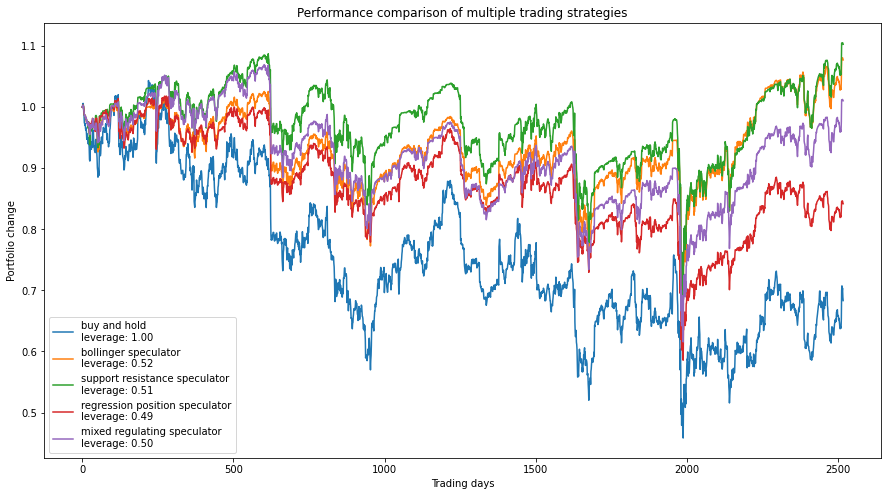

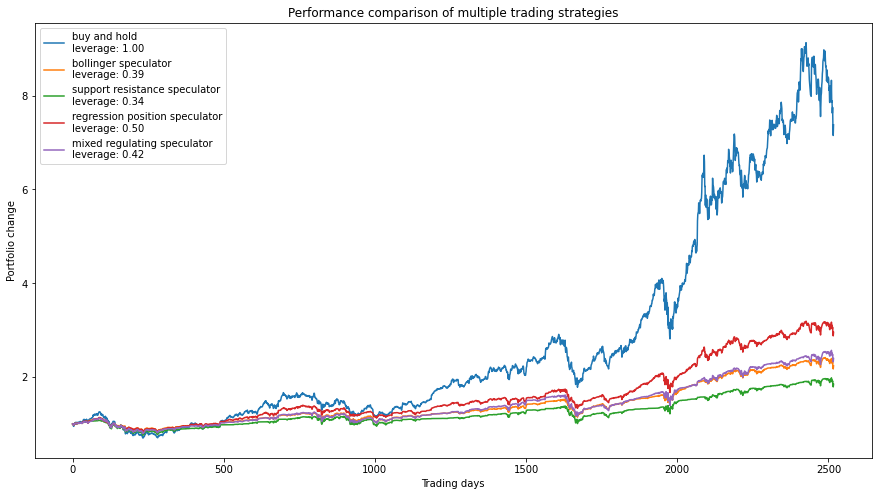

In [15]:
# try out the regulating speculator strategies
compare_strategies_individual(value_stock, regulating_speculator_strategies)
compare_strategies_individual(growth_stock, regulating_speculator_strategies)

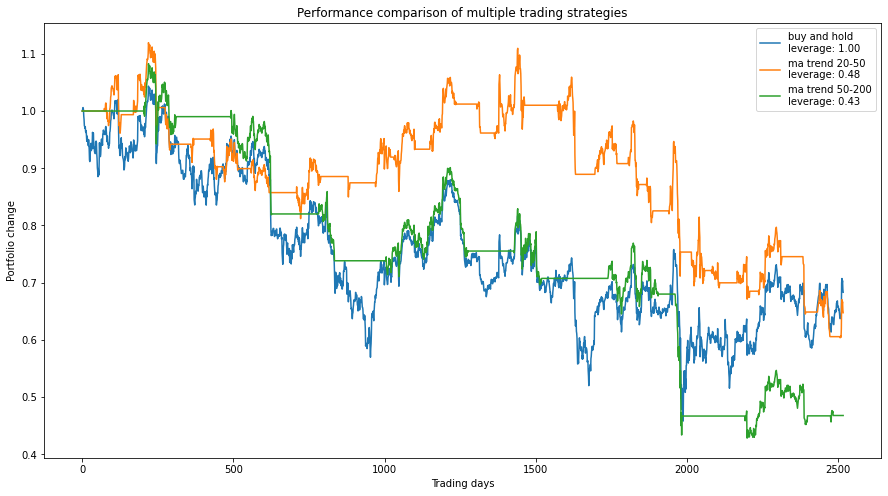

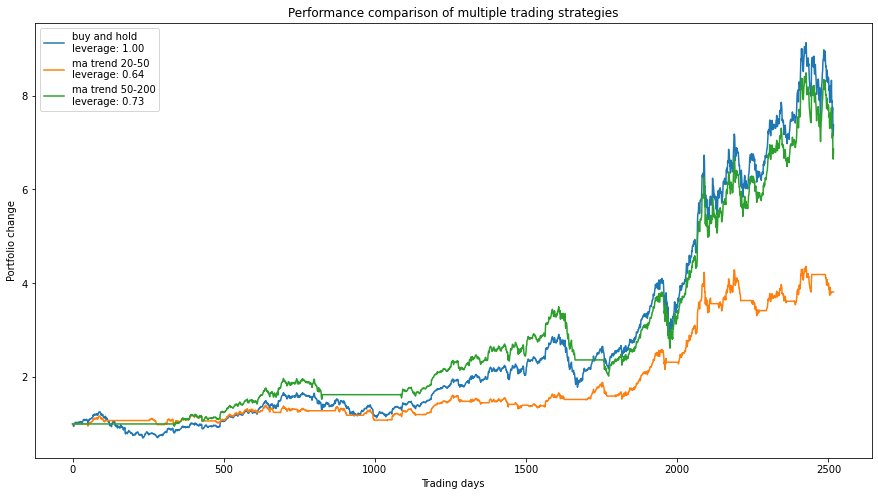

In [16]:
# try out the trendfollower
compare_strategies_individual(value_stock, trend_follower_strategies)
compare_strategies_individual(growth_stock, trend_follower_strategies)

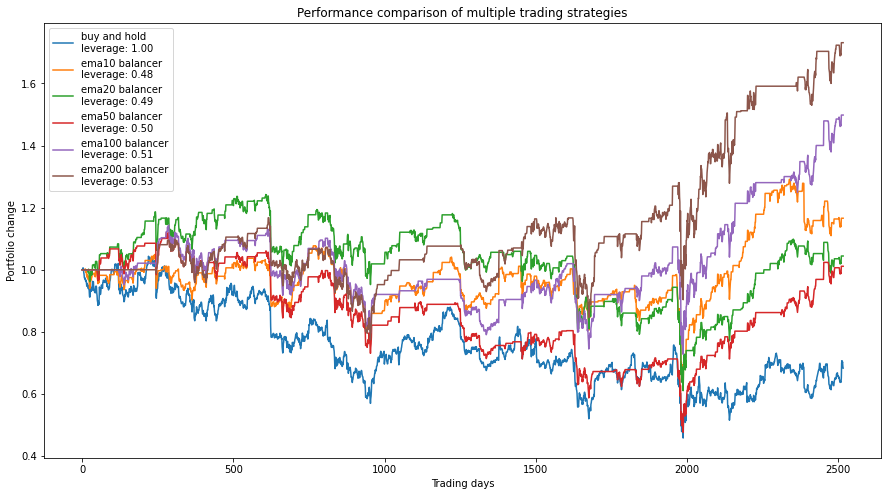

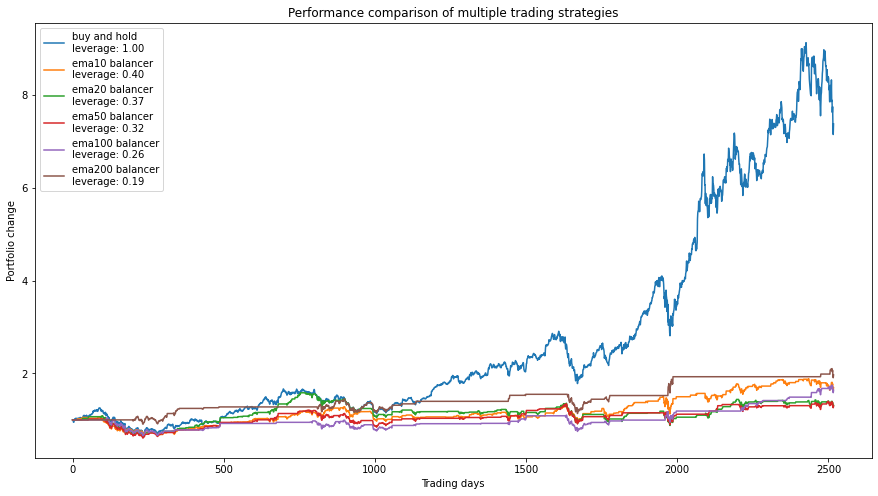

In [17]:
# try out the ema balancer
compare_strategies_individual(value_stock, ema_strategies)
compare_strategies_individual(growth_stock, ema_strategies)

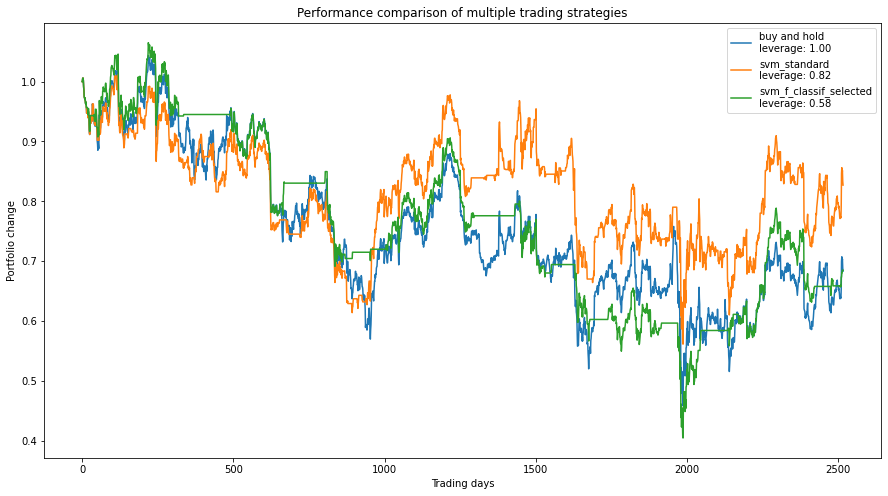

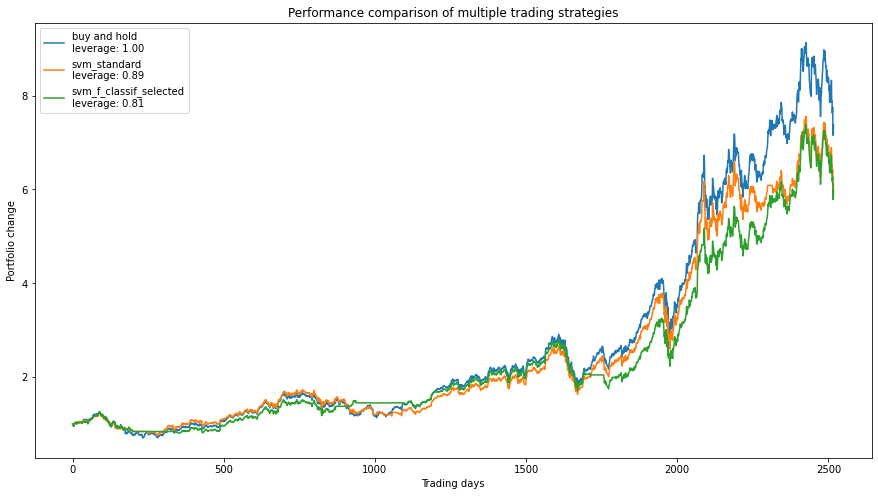

In [18]:
# try out the svm predictor
compare_strategies_individual(value_stock, svm_strategies)
compare_strategies_individual(growth_stock, svm_strategies)

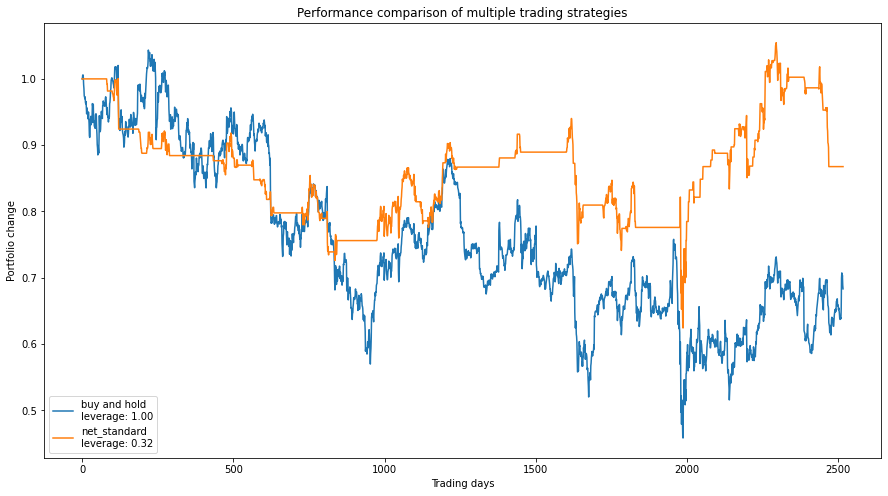

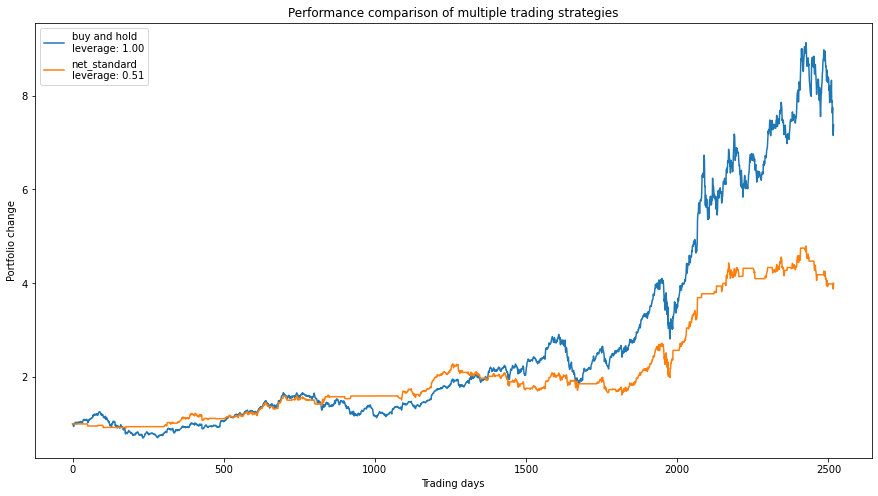

In [19]:
# try out the neural network classifier
compare_strategies_individual(value_stock, net_strategies)
compare_strategies_individual(growth_stock, net_strategies)

# Portfolio experiments:

The value of a trading strategy could be the objective selection of stocks to be involved in. To represent this behavior, a number of Finnish stocks form the Helsinki Stock Exchanges are simulated with the use of the trading strategies.

In [20]:
# define the used tickers
finland_tickers = ["NOKIA.HE","SAA1V.HE", "OUT1V.HE", "NDA1V.HE", "VALMT.HE", "SUY1V.HE", "METSA.HE", "LEM1S.HE", 
                   "ILK1S.HE", "FSC1V.HE", "CTY1S.HE", "BAS1V.HE", "CONSTI.HE", "OKDAV.HE", "DETEC.HE", "LAT1V.HE",
                   "HRTIS.HE", "ORNAV.HE", "PON1V.HE", "VERK.HE", "QPR1V.HE", "RAP1V.HE", "WUF1V.HE", "ILK2S.HE", 
                   "GLA1V.HE", "SSABBH.HE", "SOSI1.HE", "ENDOM.HE", "VIK1V.HE", "WRT1V.HE", "SSABAH.HE", 
                   "ACG1V.HE"]

# load the data
finland_assets = pd.Series({
    ticker: load_data_set("{}_normalized".format(ticker)) for ticker in finland_tickers
})

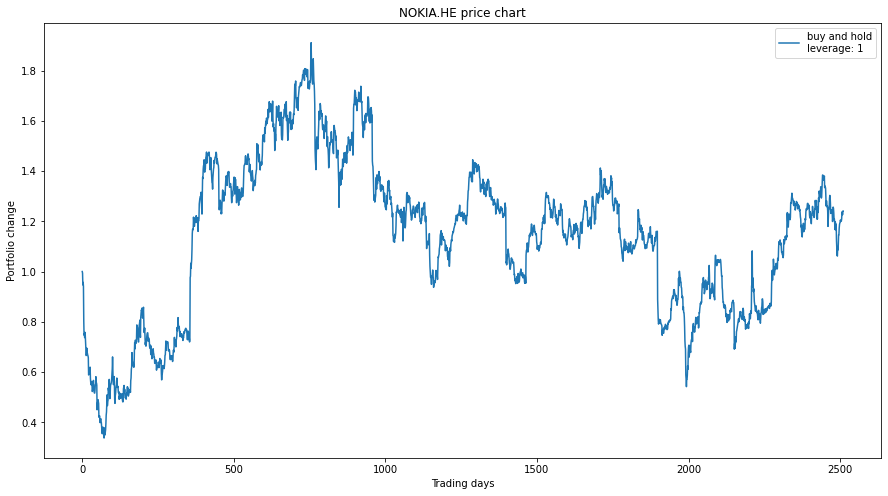

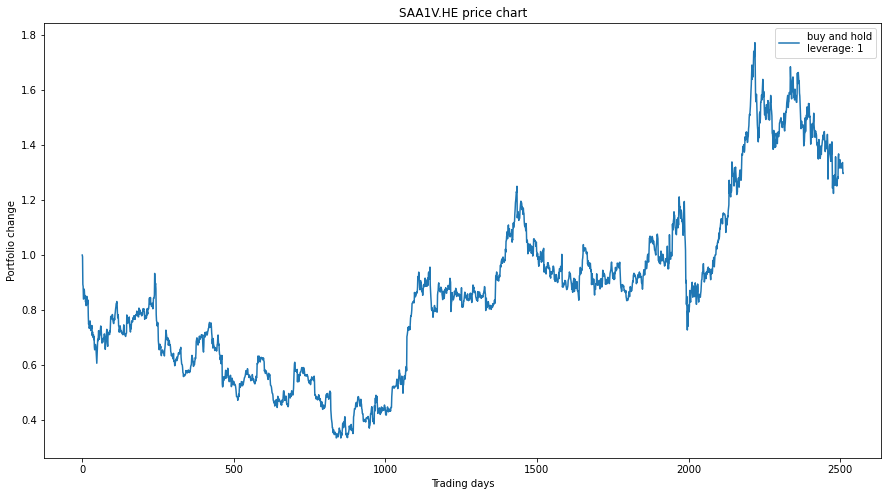

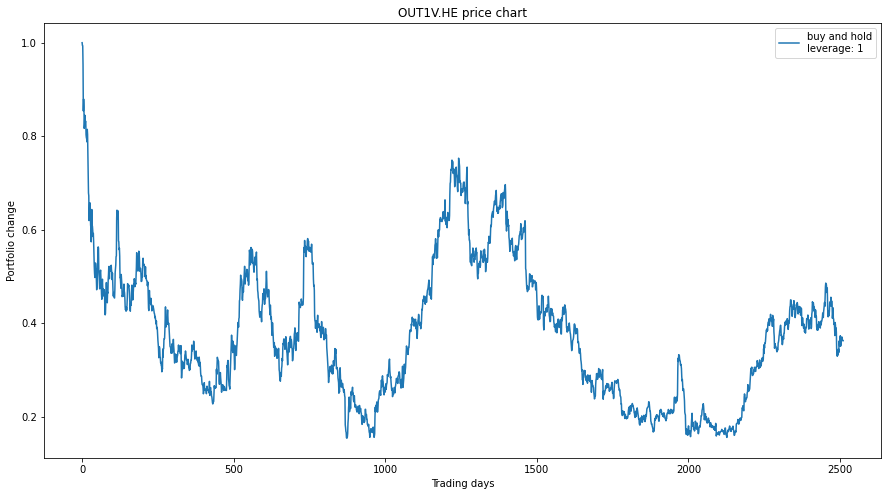

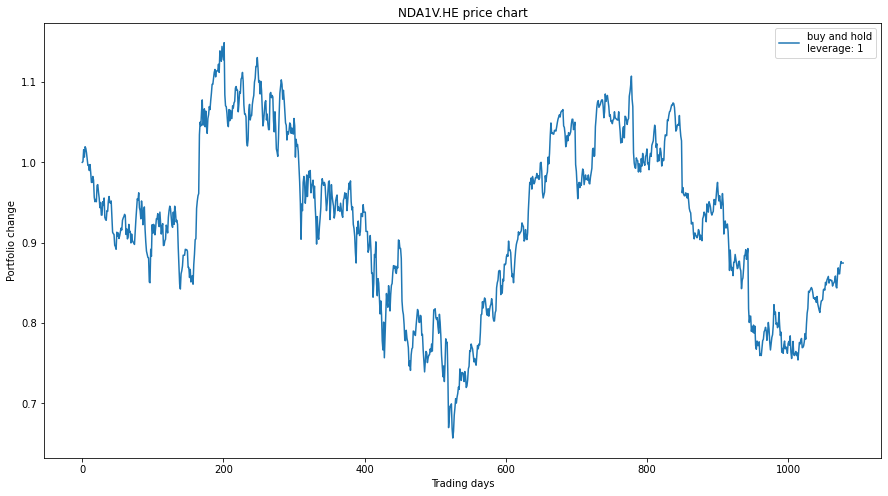

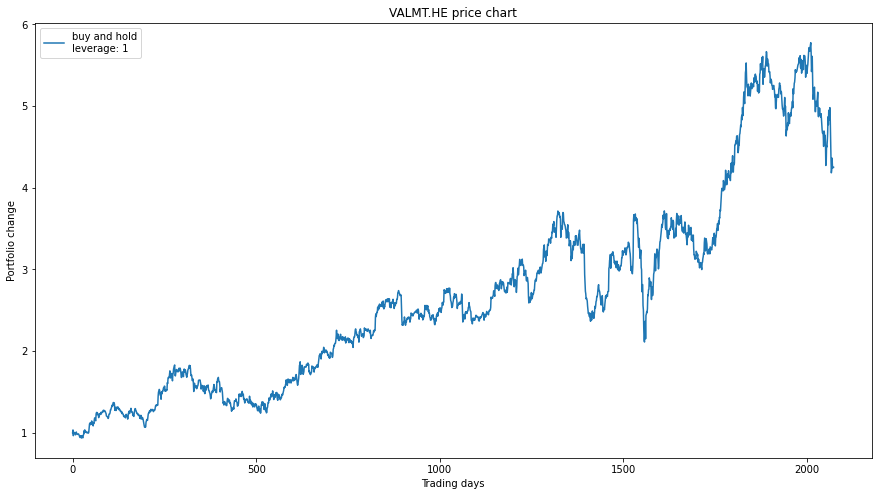

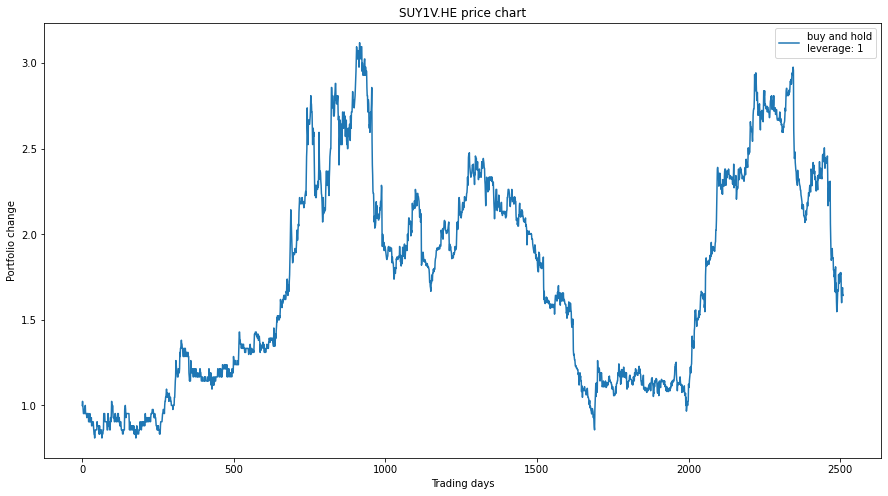

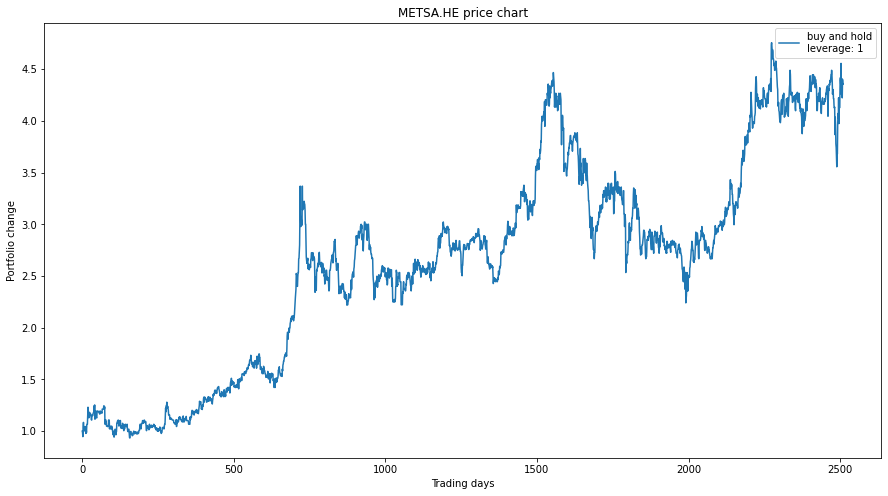

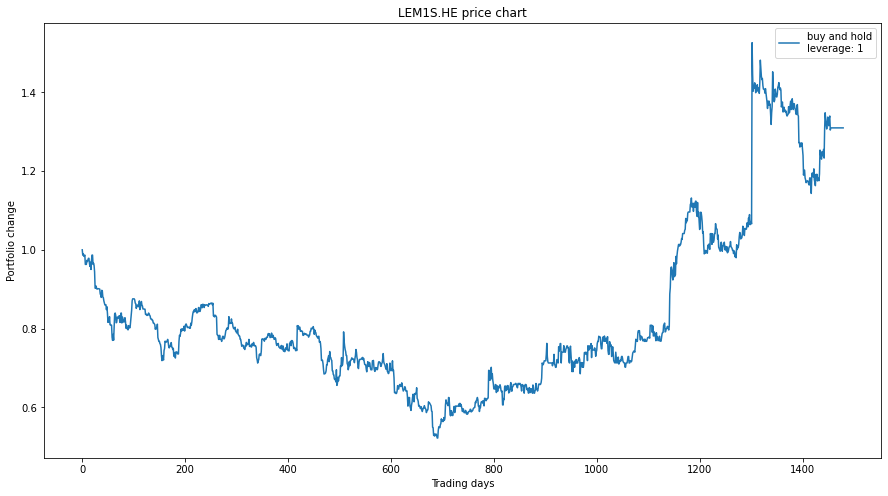

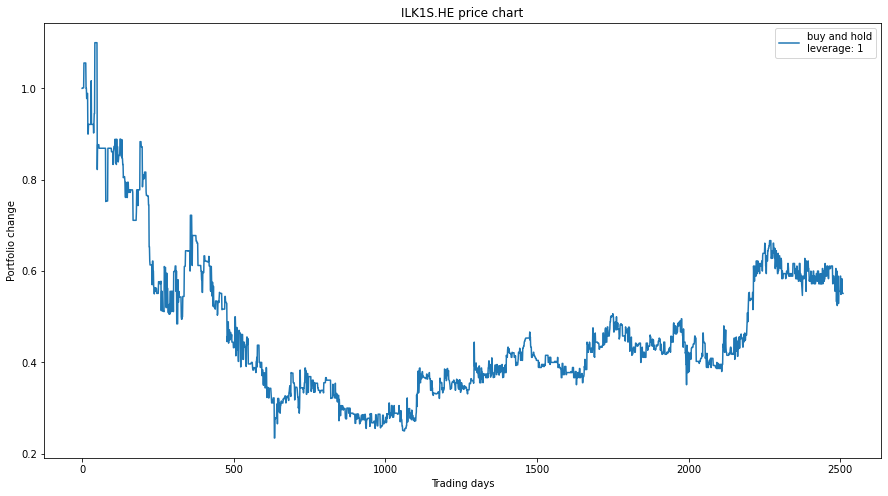

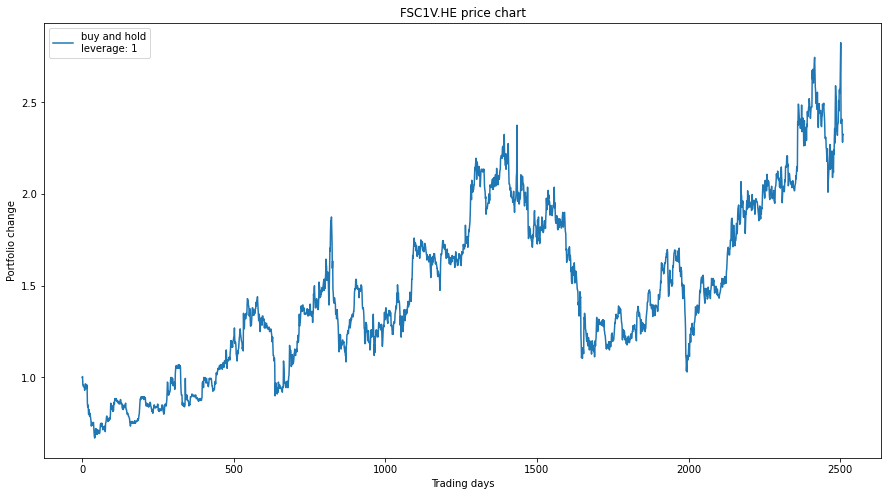

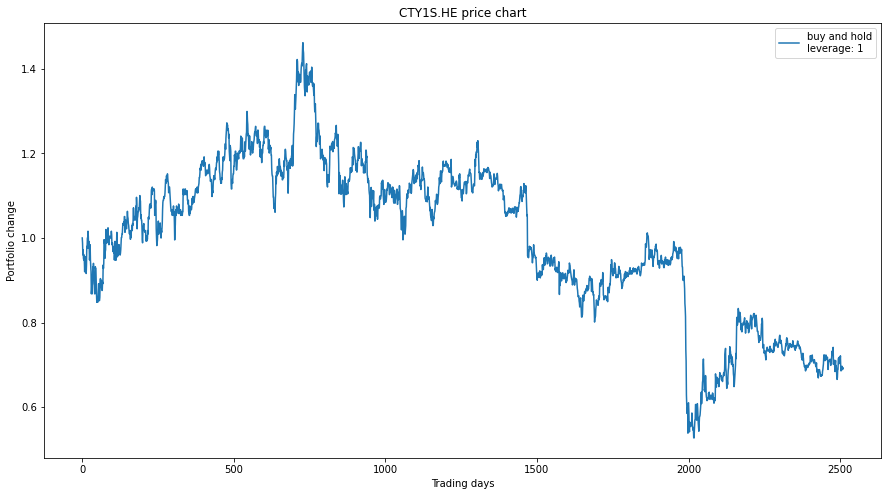

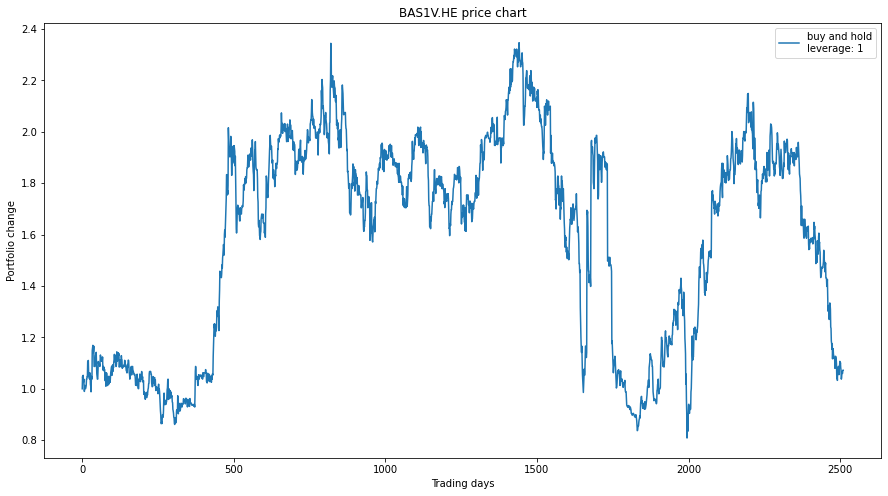

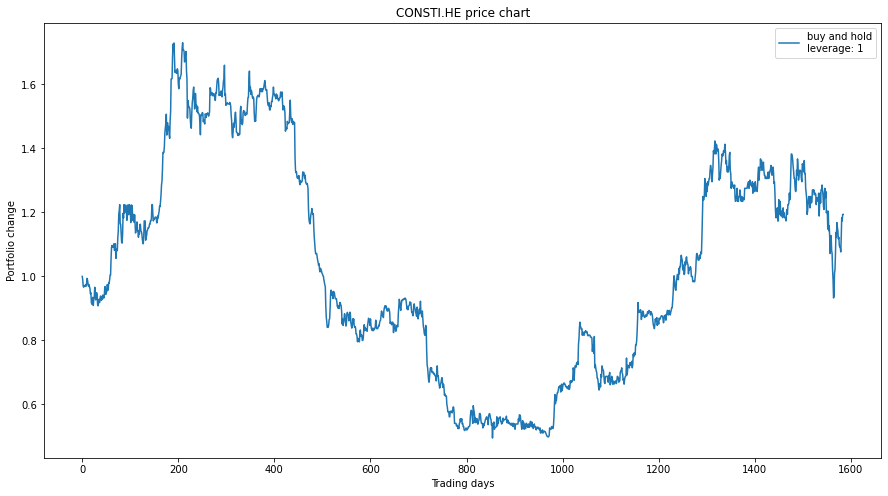

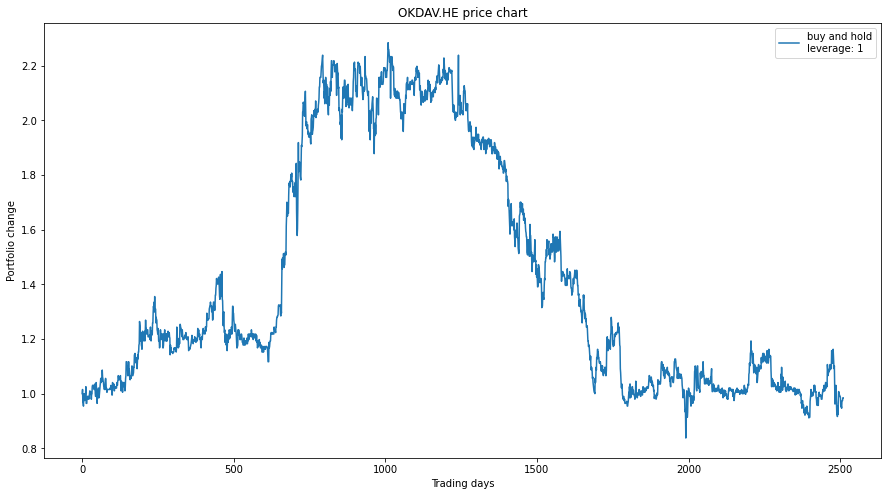

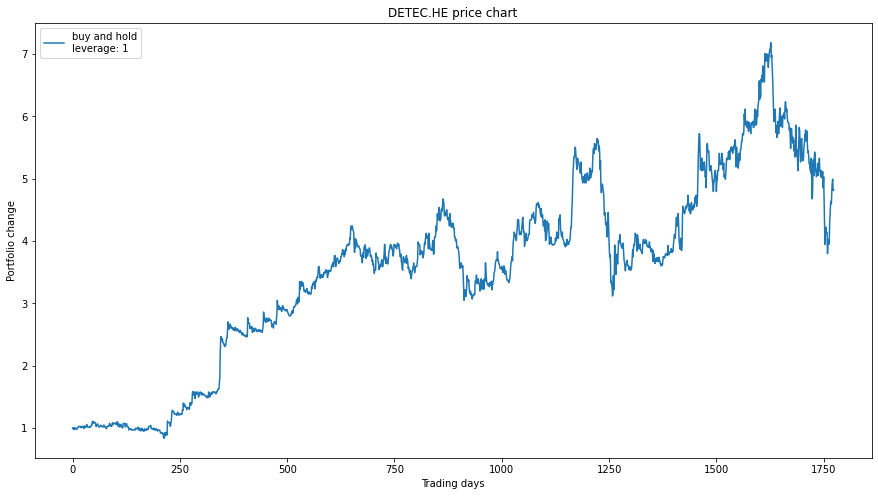

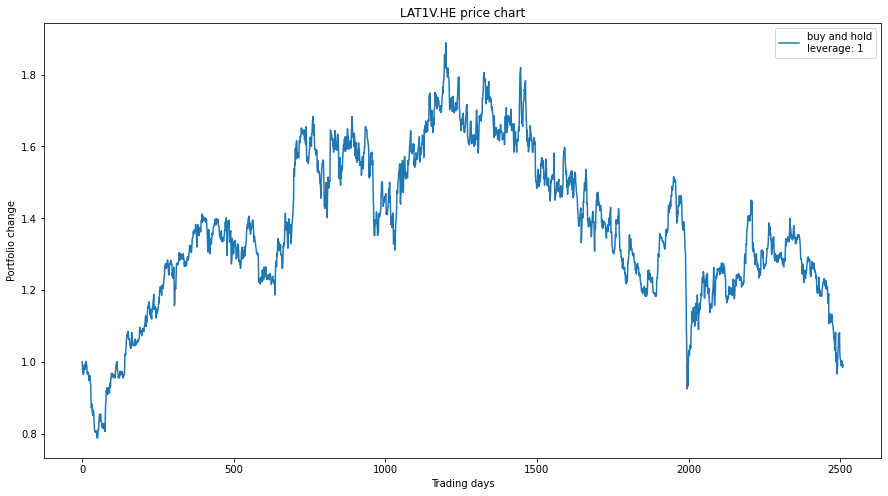

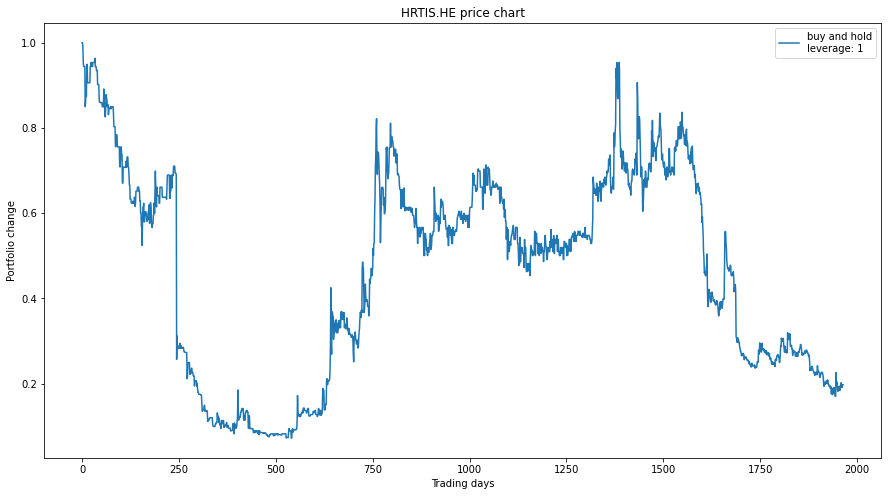

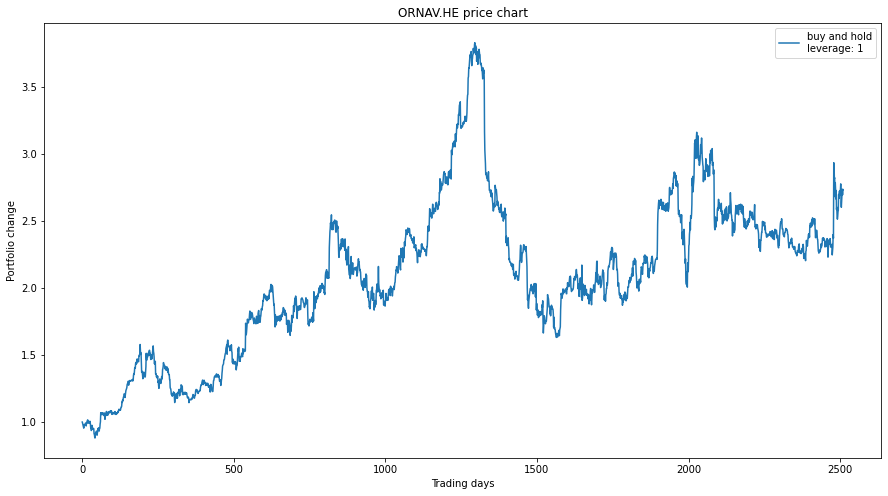

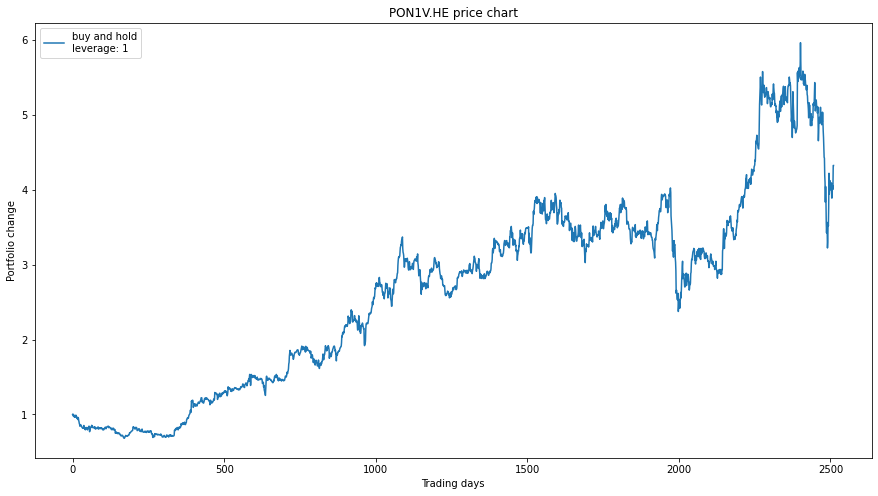

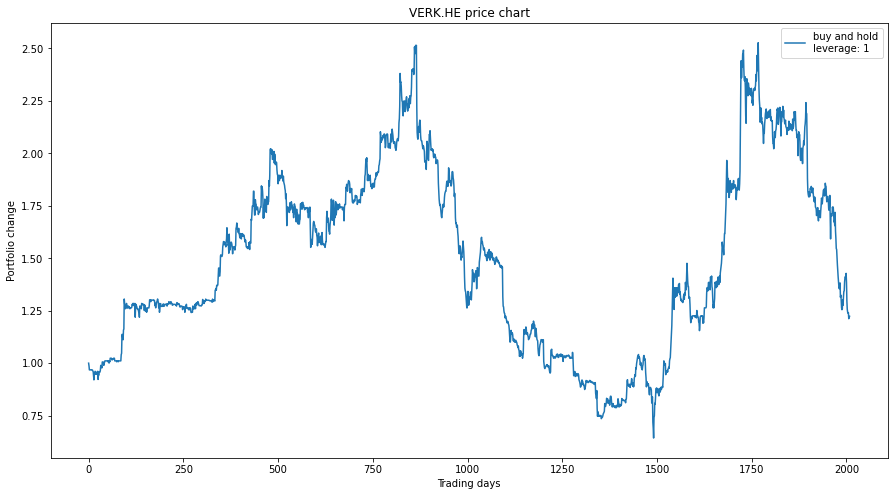

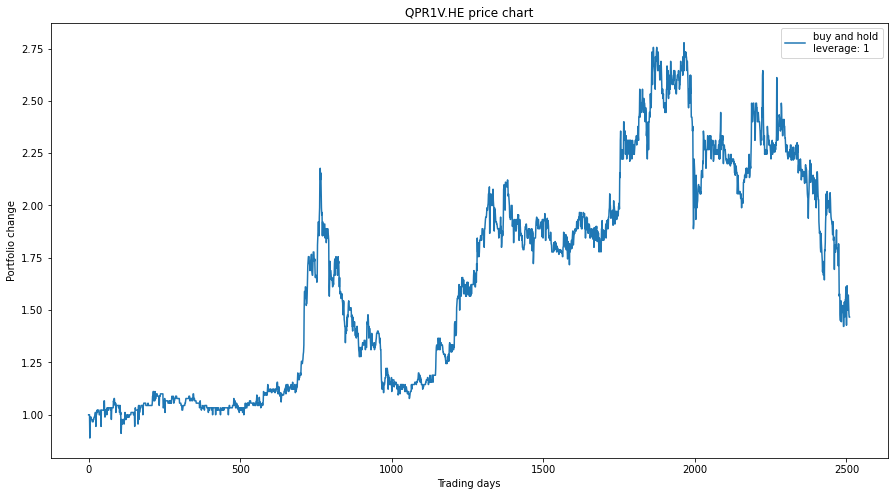

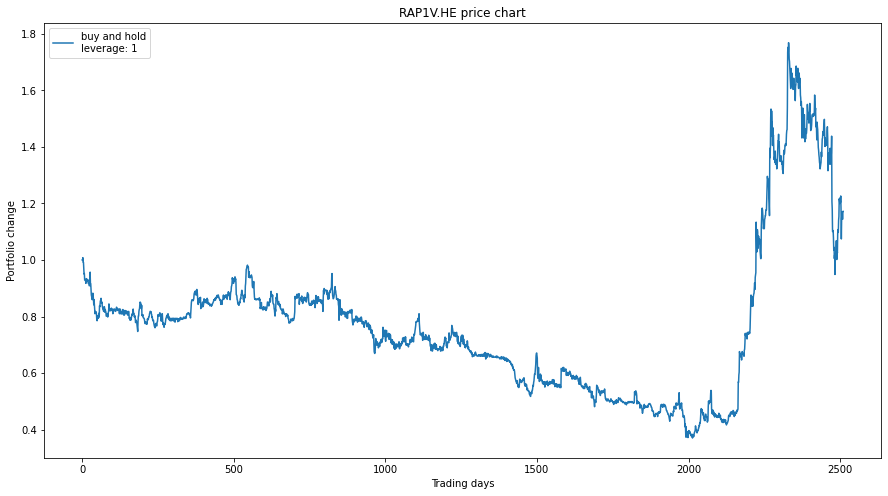

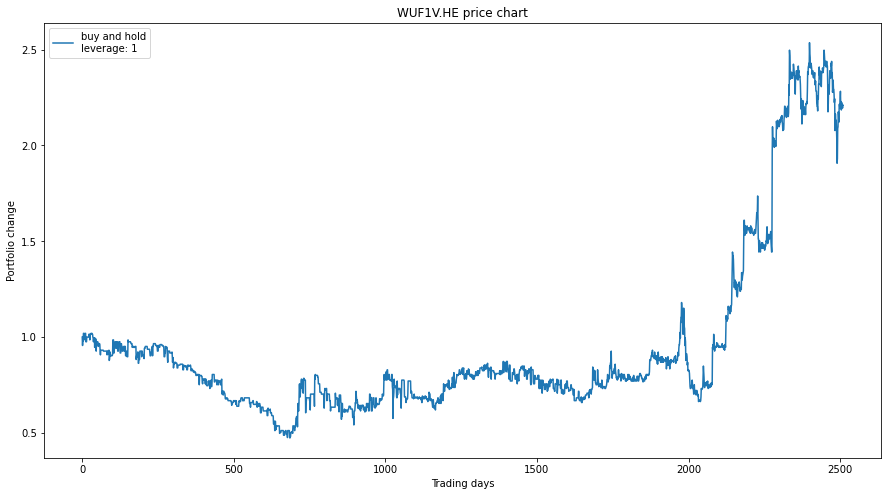

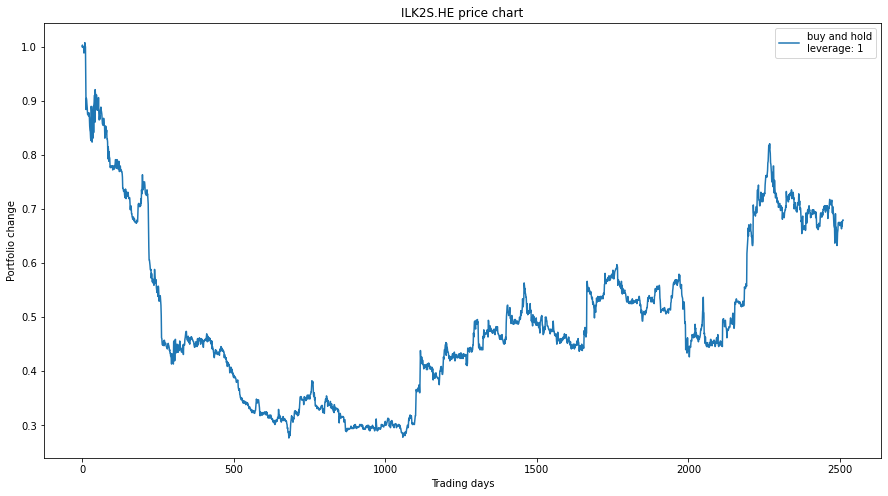

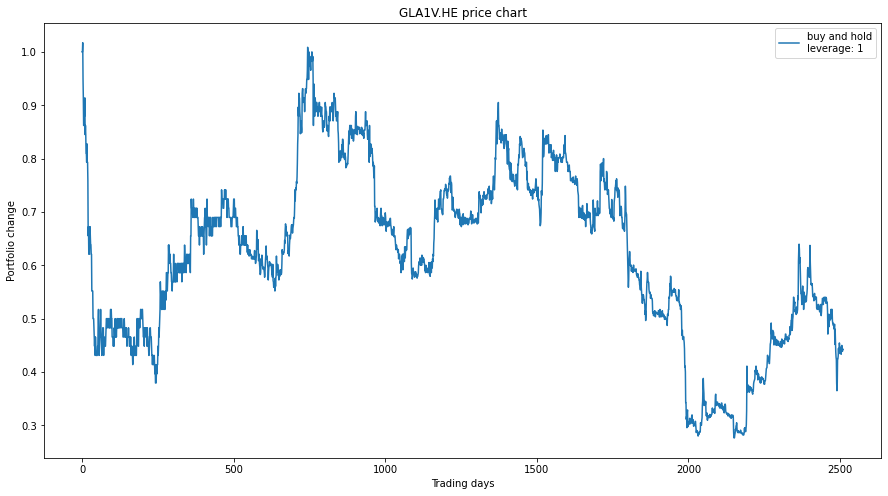

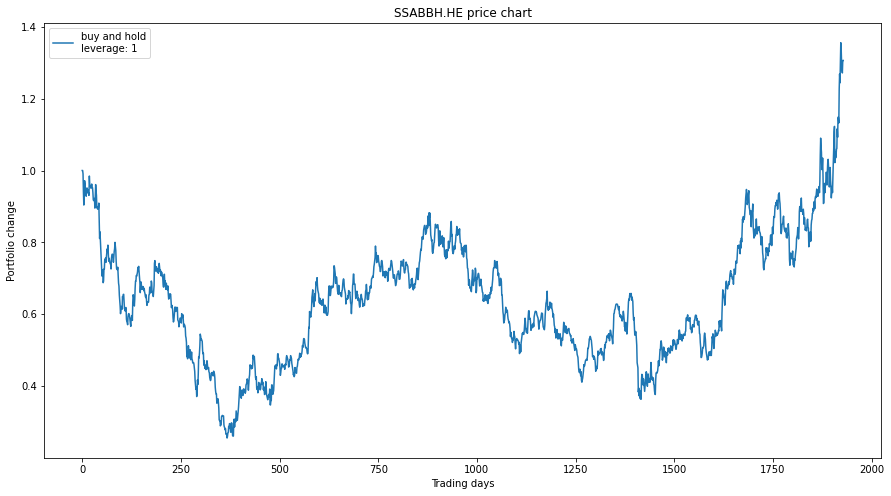

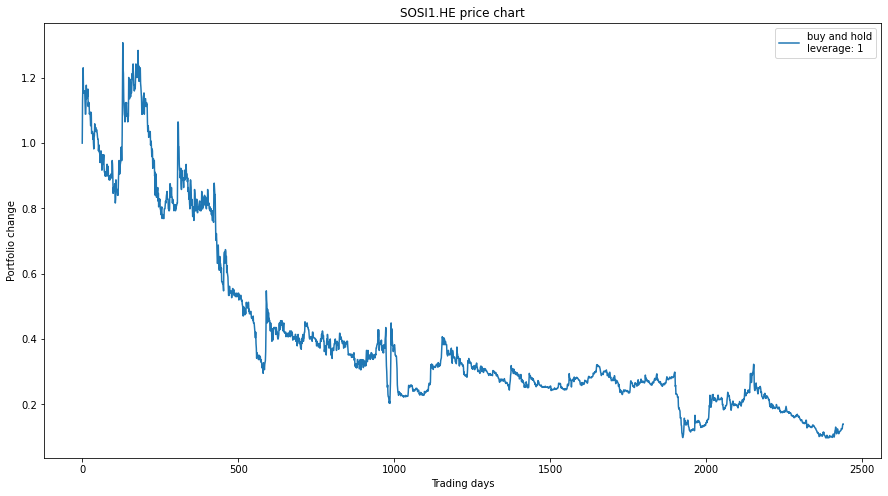

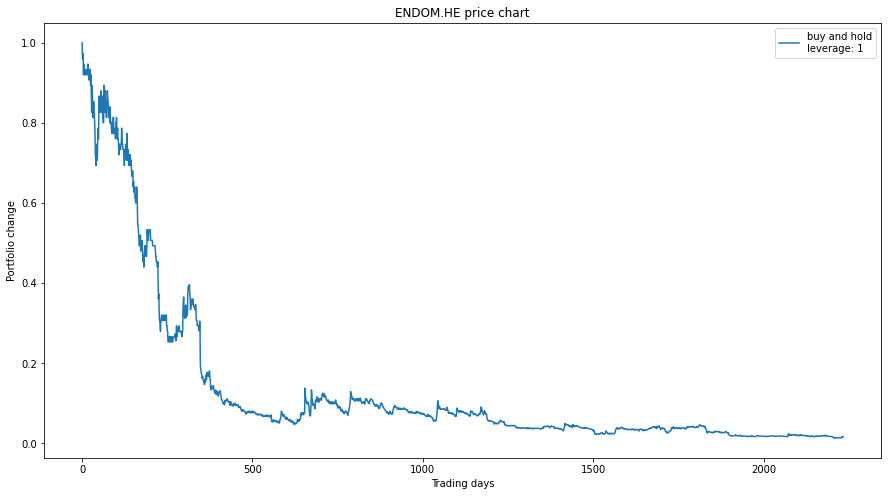

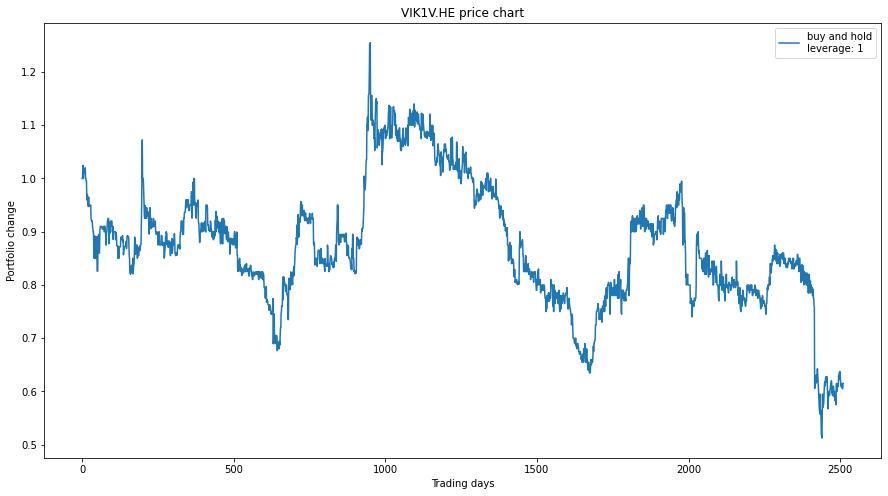

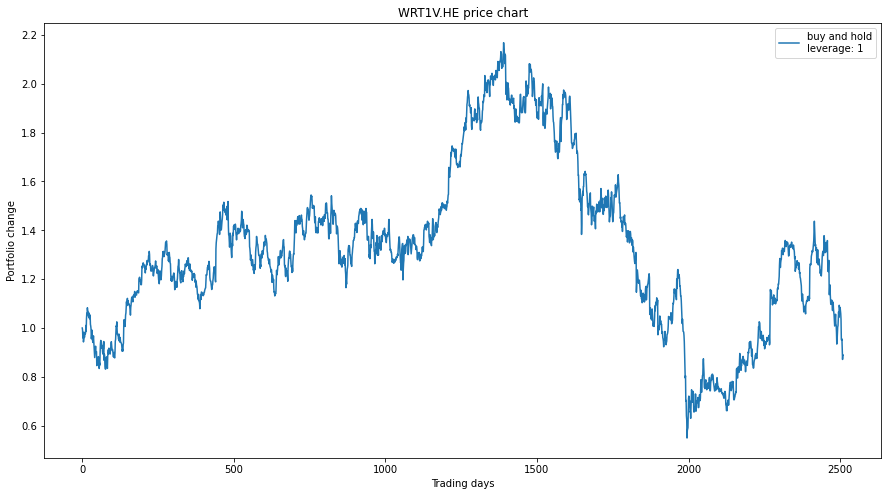

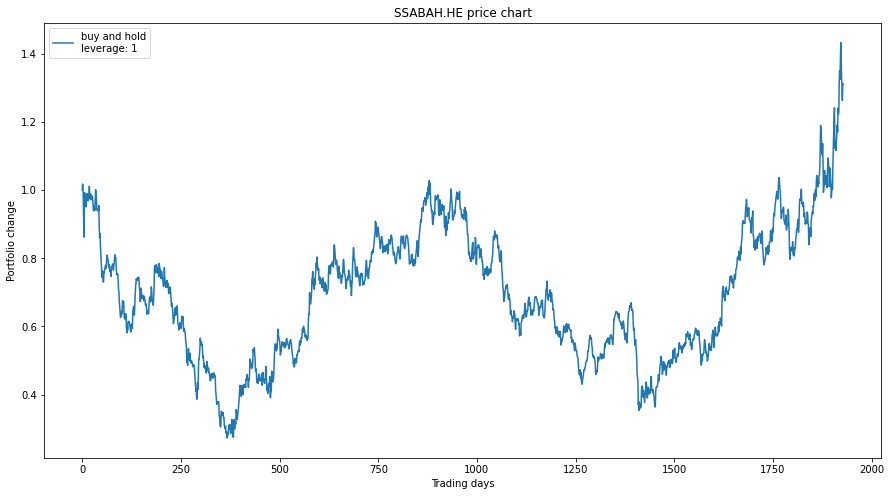

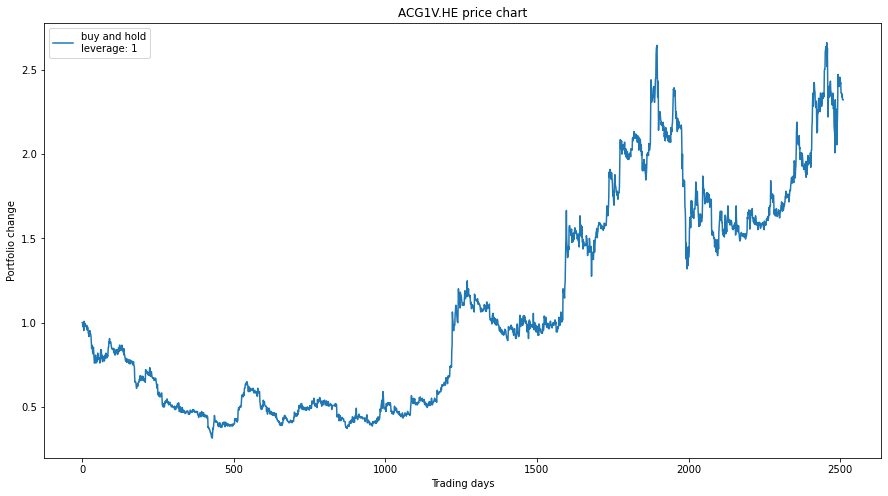

In [21]:
# show all the individual stock charts
for name, chart in finland_assets.items():
    strategy = {
        "buy and hold\nleverage: {}".format(1): chart["current_price"]
    }
    plot_performance(strategy, "{} price chart".format(name))

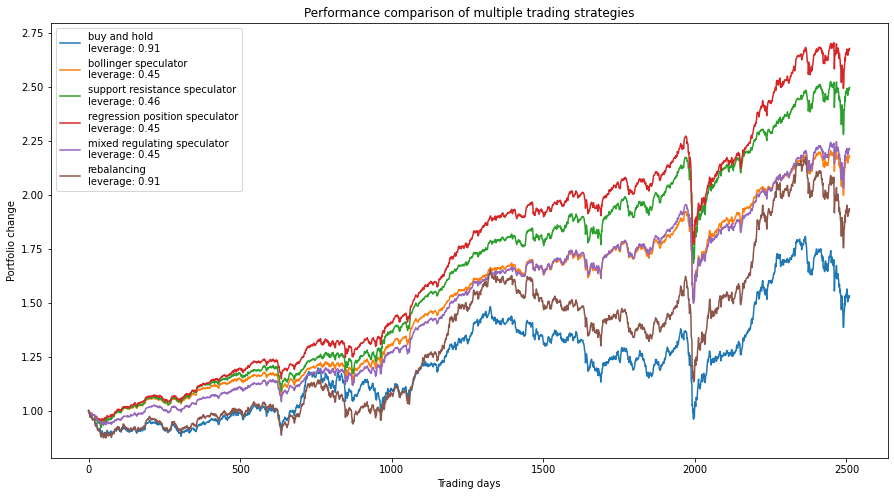

In [22]:
compare_strategies_portfolio(finland_assets, regulating_speculator_strategies, 1)

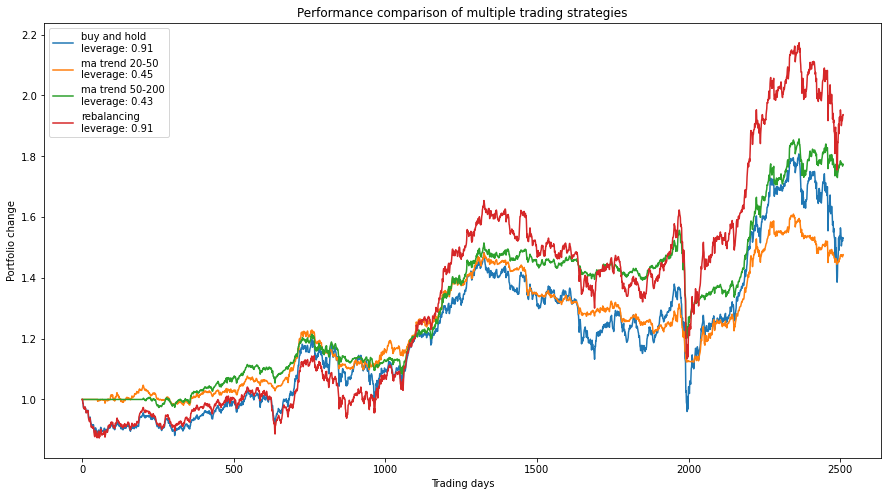

In [23]:
compare_strategies_portfolio(finland_assets, trend_follower_strategies)

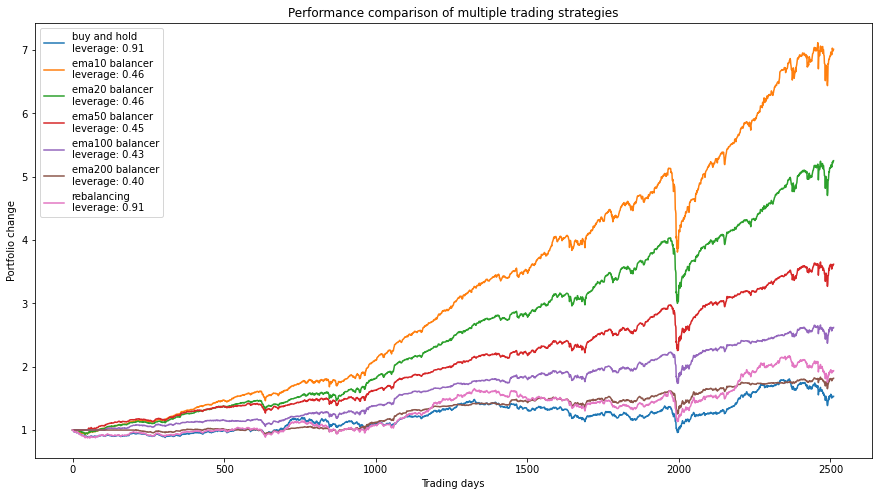

In [24]:
compare_strategies_portfolio(finland_assets, ema_strategies, 1)

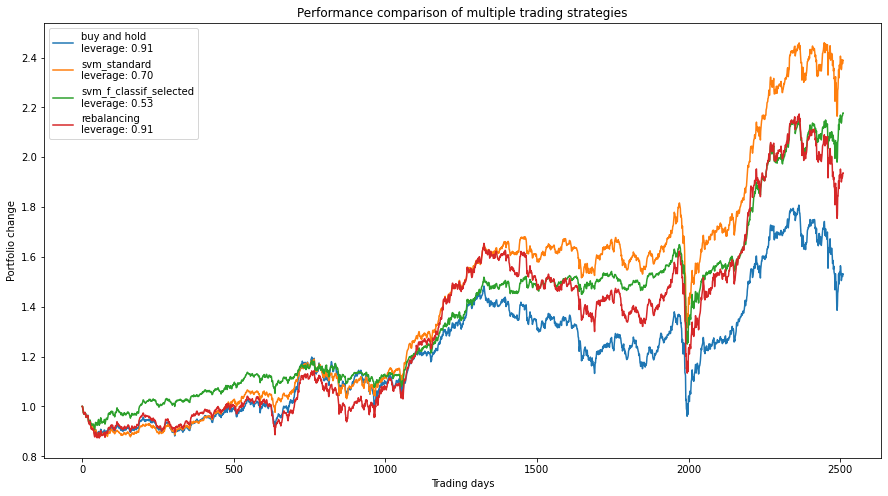

In [25]:
compare_strategies_portfolio(finland_assets, svm_strategies, 1)

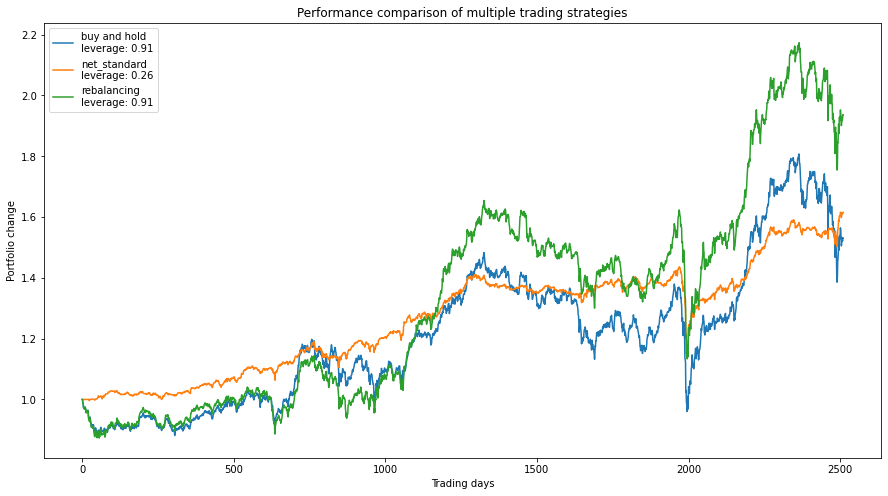

In [26]:
compare_strategies_portfolio(finland_assets, net_strategies, 1)